In [1]:
import numpy as np
import craft.craco  as craco
from craft.craco import printstats
from pylab import *

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

# plotting utilities
def myimshow(ax, d, title=None):
    ax.imshow(d, aspect='auto', origin='lower', interpolation='none')
    if title is not None:
        ax.set_title(title)
        
    return ax
    
# show waterfall of first baseline
def showcomplex(d, xlabel='', ylabel=''):
    fig, ax = subplots(1,4)
    myimshow(ax[0], d.real, 'real')
    myimshow(ax[1], d.imag, 'imag')
    myimshow(ax[2], abs(d), 'abs')
    myimshow(ax[3], np.angle(d), 'angle')
    ax[0].set_ylabel(ylabel)
    ax[1].set_xlabel(xlabel)
    fig.set_size_inches([14,5])
    return fig
    

Couldnt import numba. Bahh humbug


# How to run the CRACO model pipeline
This notebook demonstrates some of capabilities of the CRACO data processing model that's written in python. It should hopefully show you how to get started running and debugging the CRACO pipeline. There's lots of nasties in there, but you should be able to get the idea.

To start with, you might need to setup a virtualenv and install the craft package. see the README.rst at the toplevel for more details.

# Installing
Dammit, I hate installing. Why is numba so hard to get workign?? Seriously WTF?


You need to install Miriad; 
https://www.atnf.csiro.au/computing/software/miriad/INSTALL.html

# Simulating an FRB
It requires miriad to be installed see https://www.atnf.csiro.au/computing/software/miriad/ 

uvfrbsim does the following
- Uses miriad UVGEN to create a miriad datset of a poins source desired frequency setup, and antenna location and position on sky.
- Exports as fits
- Modifies the fits file to add an FRB with ones in the appropriate place and desired S/N


The primary script that creates an FRB is `uvfrbsim`

In [2]:
!uvfrbsim -h

usage: uvfrbsim [-h] [-v] [--fch1 FCH1] [--foff FOFF] [--nchan NCHAN]
                [-o OUTFILE] [--antfile ANTFILE] [--clobber] [--tint TINT]
                [--duration DURATION] [--phase_center PHASE_CENTER]
                [--stokes STOKES] [--frb_tstart FRB_TSTART] [--frb_dm FRB_DM]
                [--frb_idm FRB_IDM] [--frb_amp FRB_AMP] [--frb_sn FRB_SN]
                [--frb_relpos FRB_RELPOS]
                [--sim-method {mkfrb,mkfrb2,mkfrb_fdmt}] [--show]

Generate simulated FRB in UV data

optional arguments:
  -h, --help            show this help message and exit
  -v, --verbose         Be verbose (default: False)
  --fch1 FCH1           Center frequency of first channel (GHz) (default: 1.0)
  --foff FOFF           Bandwidth of a channel (GHz) (default: 0.001)
  --nchan NCHAN         Number of channels (default: 256)
  -o OUTFILE, --outfile OUTFILE
                        Output data file (default: frb)
  --antfile ANTFILE     Antenna file (default: askap-ak1-ak30.ant)
 

# Pre-installed antenna files that can be specified in --antfile
There some pre-installed antenna locations with the package. You can see where there are buy runnign the folowing command. You can make your own one

In [3]:
!antenna_locations -v

Antenna locations directory:/data/craco/ban115/craft-github/src/craft/data/antenna_locations
/data/craco/ban115/craft-github/src/craft/data/antenna_locations/askap-ak1-ak24.ant
/data/craco/ban115/craft-github/src/craft/data/antenna_locations/askaprel.ant
/data/craco/ban115/craft-github/src/craft/data/antenna_locations/askap-ak1-ak20.ant
/data/craco/ban115/craft-github/src/craft/data/antenna_locations/askap.ant
/data/craco/ban115/craft-github/src/craft/data/antenna_locations/askap-ak1-ak3.ant
/data/craco/ban115/craft-github/src/craft/data/antenna_locations/askap-ak1-ak36.ant
/data/craco/ban115/craft-github/src/craft/data/antenna_locations/askap-ak1-ak30.ant
/data/craco/ban115/craft-github/src/craft/data/antenna_locations/askapak1-ak30.ant


In [4]:
# You can ge the full path if you ask for a little one
!antenna_locations askap-ak1-ak24.ant

/data/craco/ban115/craft-github/src/craft/data/antenna_locations/askap-ak1-ak24.ant


 # UVFRB sim has a lot of inputs, so there's a script that makes it a bit easier to run
 

In [5]:
!craco_sim_single.sh

Need 5 arguments
Usage: /data/craco/ban115/craft-github/venv/bin/craco_sim_single.sh DM T0 AMP SN RELPOS
  DM - DM in PC/CM3
  T0 - startign time in samples
  AMP - Amplitude of output FRB
  SN - Desired Signal to noise
  RELPOS - comma separated ra_arcsec,dec_arcsec


In [6]:
# It has a bunch of defaults, writes the paramters to params.txt and params.env 
# so you can keep them for references and sutff
! cat `which craco_sim_single.sh`

#!/bin/bash

function param {
    name=$1
    shift
    echo $name $@ >> params.txt
    echo export $name=$@ >> params.env
}

if [[ $# != 5 ]] ; then
    echo "Need 5 arguments"
    echo "Usage: $0 DM T0 AMP SN RELPOS"
    echo "  DM - DM in PC/CM3"
    echo "  T0 - startign time in samples"
    echo "  AMP - Amplitude of output FRB"
    echo "  SN - Desired Signal to noise"
    echo "  RELPOS - comma separated ra_arcsec,dec_arcsec"
    exit 1
fi

( set -o posix ; set) > /tmp/myvars.before
frb_dm=$1
t0=$2 # start time in samples
frb_amp=$3
frb_sn=$4
frb_relpos=$5

# telescope and processing parameters
ncu=2
fch1=0.736 # GHz
nt=16
nd=8
nchan=256 # number of channels
tint=1.728
desired_amp=500 # desired amplitude a the output of the FFT
threshold=10
ncin=32
ndout=8
#antfile=`dirname $0`/askap-ak1-ak30.ant
#antfile=`dirname $0`/askap-ak1-ak3.ant
antfile="askap-ak1-ak24.ant"
antfile=$(antenna_locations $antfile)
echo Antfile is $antfile


# Calculated parameters
frb_relpos_frbname=$( echo 

# Let's create a single FRB and run it through the pipeline

In [7]:
%cd /tmp
!mkdir test_data
%cd test_data
! rm -Rf frb_d0_t1_a1_sninf_lm00/
! craco_sim_single.sh 0 1 1 inf 0,0 # simulate FRB at phase center, unit ampliude, infinite S/N, 1 sample offset


/tmp
mkdir: cannot create directory ‘test_data’: File exists
/tmp/test_data
Antfile is /data/craco/ban115/craft-github/src/craft/data/antenna_locations/askap-ak1-ak24.ant
ncu=2 nt=16 nd=8 frb_amp=1 nant=24 nbl=276.000000 nchan=256 desired_amp=500 raw_amp=141312.000000 scale=.003538
/tmp/test_data/frb_d0_t1_a1_sninf_lm00 /tmp/test_data
Running uvfrbsim --fch1 0.736 --nchan 256 --antfile askap-ak1-ak24.ant --tint 1.728 --duration 16 --frb_idm 0 --frb_amp 1 --frb_sn inf --frb_relpos 0,0 --frb_tstart 1.728 -o frb_d0_t1_a1_sninf_lm00.fits --sim-method mkfrb_fdmt
INFO:root:Simulating FRB. values=Namespace(antfile='/tmp/test_data/frb_d0_t1_a1_sninf_lm00/askap-ak1-ak24.ant', clobber=False, duration=16.0, fch1=0.736, foff=0.001, frb_amp=1.0, frb_dm=0, frb_idm=0.0, frb_relpos='0,0', frb_sn=inf, frb_tstart=1.728, nchan=256, outfile='frb_d0_t1_a1_sninf_lm00.fits', phase_center='0,-30', show=False, sim_method='mkfrb_fdmt', stokes='I', tint=1.728, verbose=False)
INFO:root:DM is 0 idm=0.0 fch1=0.736 

INFO:root:Finished idm=0
INFO:root:Finished idm=1
INFO:root:Finished idm=2
INFO:root:Finished idm=3
INFO:root:Finished idm=4
INFO:root:Finished idm=5
INFO:root:Finished idm=6
INFO:root:Finished idm=7
INFO:root:Saving 1 candidates to testing.cand
INFO:root:Saving file blk_0_img.npy shape=(8, 8, 256, 256) dtype=complex64
INFO:root:Saving file blk_0_grid.npy shape=(8, 8, 256, 256) dtype=complex64
/data/craco/ban115/craft-github/src/craft/craco.py:280: UserWarning: Final integration only contained t=0 of nt=16 samples len(d)=276 nrows=4692
  warnings.warn('Final integration only contained t={} of nt={} samples len(d)={} nrows={}'.format(t, nt, len(d), nrows))
INFO:root:Saving file blk_1_input.npy shape=(276, 256, 16) dtype=complex64
INFO:root:Saving file blk_1_prepare.npy shape=(894, 16, 32, 8) dtype=complex64
INFO:root:Saving file blk_1_fdmt.npy shape=(894, 16, 8, 8) dtype=complex64
INFO:root:Input shape is (894, 16, 8, 8). Writing output data to testing.img.dat shape is (nd,nt/2,npix,npi

In [8]:
# go into the working directory and have a look at the files in there
%cd frb_d0_t1_a1_sninf_lm00/
%pwd
!ls

/tmp/test_data/frb_d0_t1_a1_sninf_lm00
allvars.txt
askap-ak1-ak24.ant
blk_0_fdmt.npy
blk_0_grid.npy
blk_0_img.npy
blk_0_input.npy
blk_0_prepare.npy
blk_1_fdmt.npy
blk_1_grid.npy
blk_1_img.npy
blk_1_input.npy
blk_1_prepare.npy
frb_d0_t1_a1_sninf_lm00.fits
frb_d0_t1_a1_sninf_lm00.fits.doshift.lower.txt
frb_d0_t1_a1_sninf_lm00.fits.doshift.upper.txt
frb_d0_t1_a1_sninf_lm00.fits.frbpos
frb_d0_t1_a1_sninf_lm00.fits.gridlut.lower.txt
frb_d0_t1_a1_sninf_lm00.fits.gridlut.upper.txt
frb_d0_t1_a1_sninf_lm00.fits.mir
frb_d0_t1_a1_sninf_lm00.fits.padlut.lower.txt
frb_d0_t1_a1_sninf_lm00.fits.padlut.upper.txt
frb_d0_t1_a1_sninf_lm00.fits.uvgrid.split.txt
frb_d0_t1_a1_sninf_lm00.fits.uvgrid.txt
params.env
params.txt
testing.cand
testing.grid.dat
testing.img.dat
varchanges.txt


In [9]:
 #params that were used to generate the simulation - you can source this in your shell if you like
! cat params.env

export rundate=Thu 17 Feb 16:19:50 AEDT 2022
export frb_dm=0
export frb_t0=1
export frb_amp=1
export frb_sn=inf
export frb_relpos=0,0
export frb_tstart=1.728
export ncu=2
export fch1=0.736
export nt=16
export nd=8
export nchan=256
export tint=1.728
export desired_amp=500
export threshold=10
export antfile=/data/craco/ban115/craft-github/src/craft/data/antenna_locations/askap-ak1-ak24.ant
export frb_replos_frbname=00
export nant=24
export nbl=276.000000
export frbname=frb_d0_t1_a1_sninf_lm00
export fits=frb_d0_t1_a1_sninf_lm00.fits
export raw_image_amp=141312.000000
export scale=.003538
export ncin=32
export sim_method=mkfrb_fdmt


In [10]:
# Data are processed in blocks - labeled blk_0_* blk_1*, etc.
# INput data is blk_0_input.npy
din = np.load('blk_0_input.npy')
print(din.shape) # shape is (nbaseline, nchan, ntime)
(nbl, nchan, ntime) = din.shape
print(printstats(din.real))
print(printstats(din.imag))
print(printstats(abs(din)))

(276, 256, 16)
 max/min/mean/rms/sum/S/N = 1.00e+00/0.00e+00/6.25e-02/2.42e-01/7.07e+04/4.1 peak at (0, 0, 1)
 max/min/mean/rms/sum/S/N = 0.00e+00/0.00e+00/0.00e+00/0.00e+00/0.00e+00/0.0 peak at (0, 0, 0)
 max/min/mean/rms/sum/S/N = 1.00e+00/0.00e+00/6.25e-02/2.42e-01/7.07e+04/4.1 peak at (0, 0, 1)


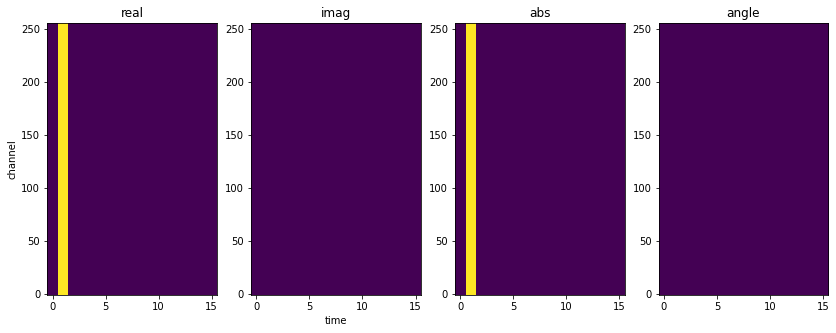

In [11]:
# shows DM=0 FRB at time=1
_ = showcomplex(din[0,:,:], 'time','channel')

(894, 16, 32, 8)


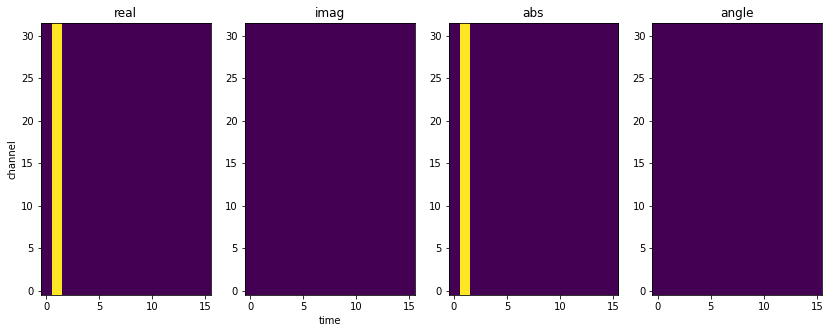

In [12]:
# prepare is the data split into 32-channel (or less) chunks for the FDMT
dprep = np.load('blk_0_prepare.npy')
print(dprep.shape) 
(nuvrest, ntime, ncin, nuvwide) = dprep.shape
# NUVREST axis is the number of times the FDMT is executed. 
# NTIME is the number of time samples, N
# ncin is the number of input channels to the FDMT (fixed at 32) 
# nuvwide is the number of UV cells processed simultaneously (fixed at 8)

# here's the input to the first UV Cell
# note only 32 channels now, but all completely filled
_ = showcomplex(dprep[0,:,:,0].T, 'time','channel')


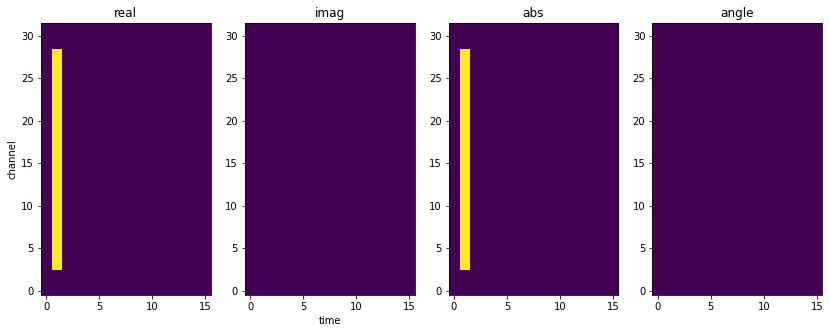

In [14]:
# show last UV in teh 6th run - see how it's padded because not all the channels fit in the frequency range for this
# set of UV cells
_ = showcomplex(dprep[5,:,:,-1].T, 'time','channel')


(894, 16, 8, 8)
 max/min/mean/rms/sum/S/N = 1.25e-01/0.00e+00/7.81e-03/1.74e-02/1.00e+00/7.2 peak at (0, 1)


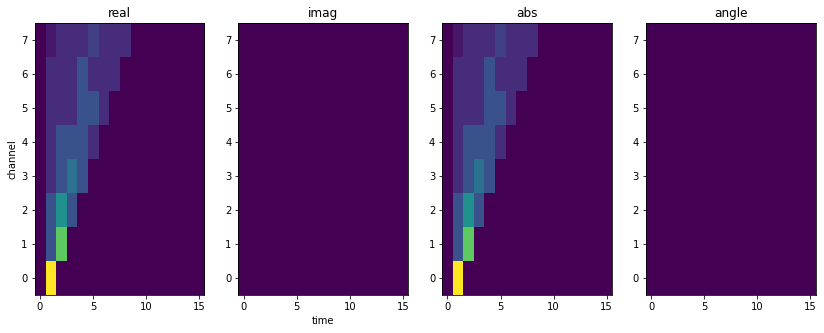

In [15]:
# output of FDMT
dfdmt = np.load('blk_0_fdmt.npy')
print(dfdmt.shape)
(nuvrest, nt, ndout, nuvwide) = dfdmt.shape
# Show FDMT of first UV point
_ = showcomplex(dfdmt[0,:,:,0].T, 'time','channel')
print(printstats(abs(dfdmt[0,:,:,0].T)))

 max/min/mean/rms/sum/S/N = 1.02e-01/0.00e+00/6.35e-03/1.52e-02/8.12e-01/6.7 peak at (0, 1)


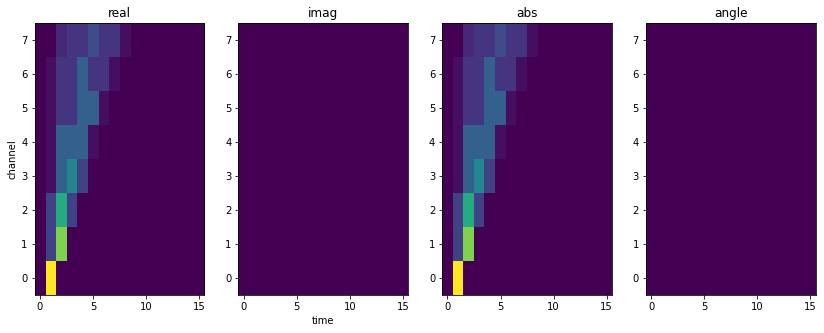

In [16]:
# Show FDMT of first UV point
_ = showcomplex(dfdmt[5,:,:,-1].T, 'time','channel')
print(printstats(abs(dfdmt[5,:,:,-1].T))) 

# Note how peak is lower

(8, 8, 256, 256)


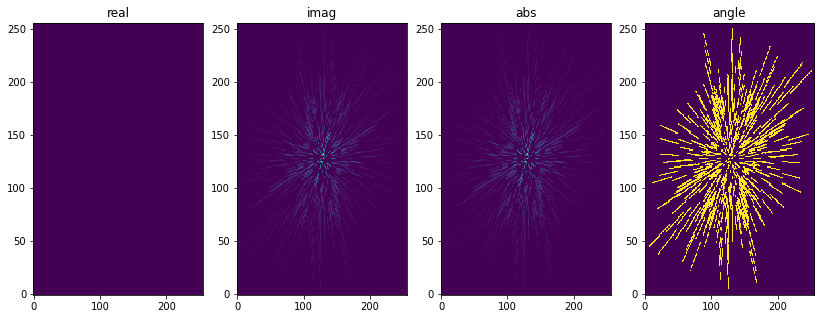

In [17]:
# Let's look at the UV grid
dgrid = np.load('blk_0_grid.npy')
print(dgrid.shape)
ndm, nt, npix, npix = dgrid.shape
f = showcomplex(dgrid[0,0,:,:])


complex64 (8, 8, 256, 256)
 max/min/mean/rms/sum/S/N = 1.00e+01/-3.98e-01/3.07e-12/3.10e-02/2.57e-05/322.4 peak at (0, 1, 128, 128)


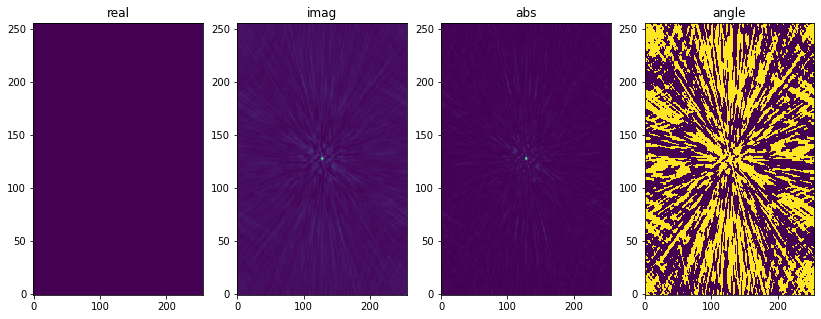

In [18]:
# let's look at images.
dimg = np.load('blk_0_img.npy')
print(dimg.dtype, dimg.shape)
(nd, nton2, npix, npix) = dimg.shape

# Shoudl look like the point spread funciton. It appears in the imaginary part because the 
# gridding has loaded 2 time samples in as hermetian conjugates, so that time=0 arrives in teh real part
# and time=1 arrives in the complex part
_ = showcomplex(dimg[0,0,:,:])
(ndm, nton2, npix, npix) = dimg.shape
# Reshape images in real-valued array.
# Evens are real, odds are imaginary
times = np.zeros((ndm, nton2*2, npix, npix), dtype=np.float32)
times[:,0::2,:,:] = dimg.real
times[:,1::2,:,:] = dimg.imag
print(printstats(times))


In [19]:
# ANd finally, just what you wanted to see - what are the candidates?
# 1 candidate, DM=0, time=1, middle of teh road, boxcar=1 and S/N=10.0
! cat testing.cand

# idm t xpix ypix boxwidth sn
0 1 128 128 1 10.0


# We have a bunch of canonical Tests we can create and look at

In [20]:
# Run this script if you want to wait a while and see what things look like.
! cat `which craco_sim_batch.sh`
# ! craco_sim_batch.sh # Uncomment and run if you're prepared to wait

#!/bin/bash

#    frb_idm=$1
#    t0=$2 # start time in samples
#    frb_amp=$3
#    frb_sn=$4
#    frb_relpos=$5

craco_sim_single.sh 0 0 1 inf 0,0
# Canonical:  unit FRB at center at 0 DM
craco_sim_single.sh 0 1 1 inf 0,0 # canonical + toff=1 samlpes
craco_sim_single.sh 0 2 1 inf 0,0 # canonical + toff=2 samlpes
craco_sim_single.sh 0 3 1 inf 0,0 # canonical + toff=3 samlpes
craco_sim_single.sh 0 4 1 inf 0,0 # canonical + toff=4 samlpes
craco_sim_single.sh 0 9 1 inf 0,0 # canonical + toff=9 samlpes
craco_sim_single.sh 2 0 1 inf 0,0 # canonical + dm=2
craco_sim_single.sh 0 0 2 inf 0,0 # canonical + amplitude=2
craco_sim_single.sh 0 0 1 inf 100,200 # canonical + position offset = 100" in ra and 200" in dec
craco_sim_single.sh 0 0 1 10 0,0 # Canonical + S/N = 12

craco_sim_single.sh 6 2 1 inf 0,0 #
craco_sim_single.sh 6 2 1 inf 300,400 # 
craco_sim_single.sh 6 2 1 10  300,400 # 


# How about a tricky one?

In [21]:
%cd /tmp/test_data/
! craco_sim_single.sh 6 2 1 10  300,400 # DM=6, starting at t=2, amplitude=1, S/N=10, offset from center

/tmp/test_data
Antfile is /data/craco/ban115/craft-github/src/craft/data/antenna_locations/askap-ak1-ak24.ant
ncu=2 nt=16 nd=8 frb_amp=1 nant=24 nbl=276.000000 nchan=256 desired_amp=500 raw_amp=141312.000000 scale=.003538
mkdir: cannot create directory ‘frb_d6_t2_a1_sn10_lm300400’: File exists
/tmp/test_data/frb_d6_t2_a1_sn10_lm300400 /tmp/test_data
Running uvfrbsim --fch1 0.736 --nchan 256 --antfile askap-ak1-ak24.ant --tint 1.728 --duration 16 --frb_idm 6 --frb_amp 1 --frb_sn 10 --frb_relpos 300,400 --frb_tstart 3.456 -o frb_d6_t2_a1_sn10_lm300400.fits --sim-method mkfrb_fdmt
INFO:root:Simulating FRB. values=Namespace(antfile='/tmp/test_data/frb_d6_t2_a1_sn10_lm300400/askap-ak1-ak24.ant', clobber=False, duration=16.0, fch1=0.736, foff=0.001, frb_amp=1.0, frb_dm=0, frb_idm=6.0, frb_relpos='300,400', frb_sn=10.0, frb_tstart=3.456, nchan=256, outfile='frb_d6_t2_a1_sn10_lm300400.fits', phase_center='0,-30', show=False, sim_method='mkfrb_fdmt', stokes='I', tint=1.728, verbose=False)
INFO:

In [22]:
%cd frb_d6_t2_a1_sn10_lm300400

/tmp/test_data/frb_d6_t2_a1_sn10_lm300400


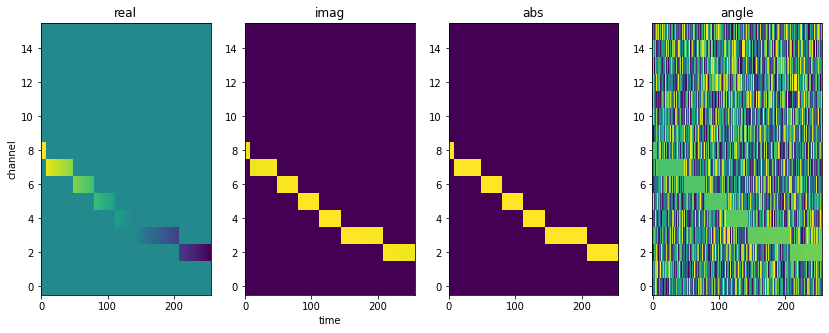

In [23]:
din = np.load('blk_0_input.npy')
_ = showcomplex(din[0,:,:].T, 'time','channel')

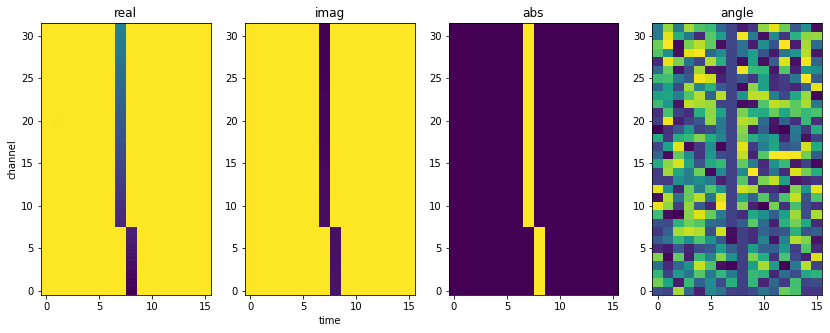

In [24]:
# prepare is the data split into 32-channel (or less) chunks for the FDMT
dprep = np.load('blk_0_prepare.npy')
_ = showcomplex(dprep[0,:,:,0].T, 'time','channel')


 max/min/mean/rms/sum/S/N = 1.25e-01/5.55e-07/7.81e-03/1.90e-02/1.00e+00/6.6 peak at (1, 8)


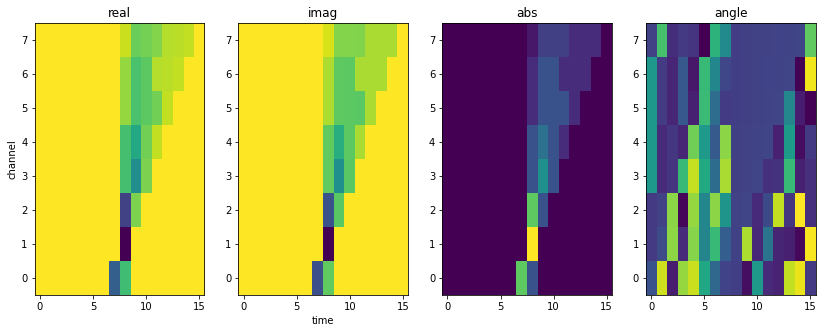

In [25]:
# output of FDMT
dfdmt = np.load('blk_0_fdmt.npy')
_ = showcomplex(dfdmt[0,:,:,0].T, 'time','channel')
print(printstats(abs(dfdmt[0,:,:,0].T)))

(8, 8, 256, 256)


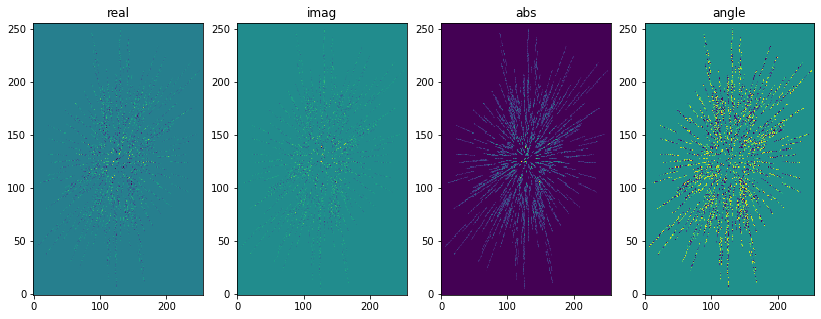

In [26]:
# Let's look at the UV grid
dgrid = np.load('blk_0_grid.npy')
print(dgrid.shape)
ndm, nt, npix, npix = dgrid.shape
f = showcomplex(dgrid[0,0,:,:])

complex64 (8, 8, 256, 256)
 max/min/mean/rms/sum/S/N = 6.67e+00/-3.05e-01/1.75e-10/1.21e-01/1.14e-05/55.3 peak at (145, 142)
 max/min/mean/rms/sum/S/N = 1.65e+00/-1.10e-01/0.00e+00/4.08e-02/0.00e+00/40.4 peak at (145, 142)
 max/min/mean/rms/sum/S/N = 6.87e+00/1.61e-04/9.05e-02/8.96e-02/5.93e+03/76.7 peak at (145, 142)


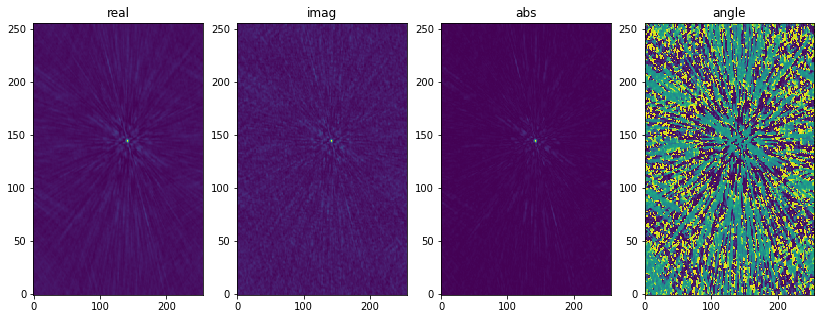

In [27]:
# let's look at images - where the FRB is we see it with high S/N
dimg = np.load('blk_0_img.npy')
print(dimg.dtype, dimg.shape)
(nd, nton2, npix, npix) = dimg.shape
_ = showcomplex(dimg[6,4,:,:])
print(printstats(dimg[6,4,:, :].real)) # Print maximum for even-numbered time samples
print(printstats(dimg[6,4,:, :].imag)) # Print maximum for odd times amples - the peak should be here, as our original data was here
print(printstats(abs(dimg[6,4,:, :]))) 


In [28]:
# OK - so at this point I'm a bit foncused - because the FRB is spread over 2 samples, the S/N is huge
# but the amplitude is small. *sigh*.

(ndm, nton2, npix, npix) = dimg.shape
times = np.zeros((ndm, nton2*2, npix, npix), dtype=np.float32)
# Evens are real, odds are imaginary
times[:,0::2,:,:] = dimg.real
times[:,1::2,:,:] = dimg.imag

Text(0.5, 1.0, 'Time series for pixel 145, 142')

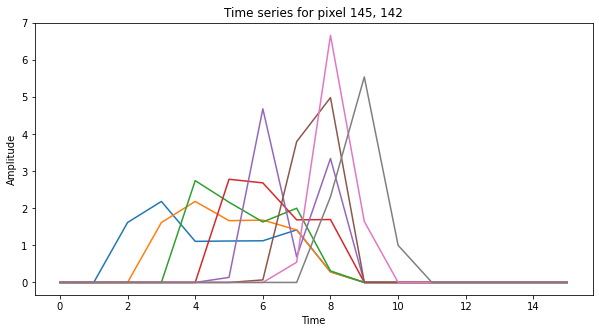

In [29]:
plot(times[:, :, 145, 142].T)
xlabel('Time')
ylabel('Amplitude')
title('Time series for pixel 145, 142')

Text(0.5, 1.0, 'Waterfall for pixel 145, 142')

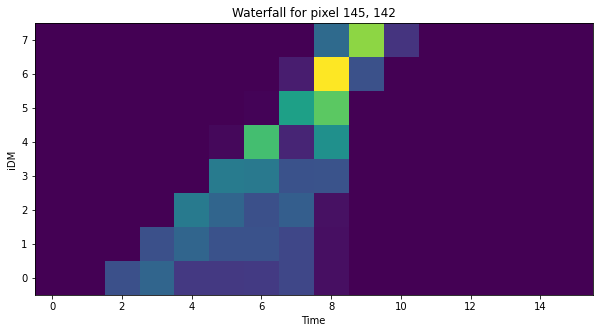

In [30]:
imshow(times[:,:, 145, 142], aspect='auto', origin='lower')
xlabel('Time')
ylabel('iDM')
title('Waterfall for pixel 145, 142')